In [1]:
# Loading datasets
import torch
import torchvision

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=25,
                                           shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True, num_workers=4)

print(trainset.data.size())
print("Done importing data.")


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!
torch.Size([60000, 28, 28])
Done importing data.


D:\Programs\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(ConvNet())

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [3]:
import torch.optim as optim

net = ConvNet()

CUDA=torch.cuda.is_available()
if CUDA:
    net.cuda()

# Let's first define our device as the first visible cuda device if we have
# CUDA available:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
print(torch.cuda.get_device_name(device=device))

cuda:0
NVIDIA GeForce GTX 1650


In [5]:
# 4. Train the network
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
accuracy_values=[]
epoch_number=[]
for epoch in range(10):  # loop over the dataset multiple times. Here 10 means 10 epochs
    running_loss = 0.0
    for i, (inputs,labels) in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if CUDA:
          inputs = inputs.cuda()
          labels = labels.cuda()
        else:
          inputs = inputs.cpu()
          labels = labels.cpu()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[epoch%d, itr%5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if CUDA:
              images = images.cuda()
              labels = labels.cuda()
            else:
              images = images.cpu()
              labels =labels.cpu()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if CUDA:
              correct += (predicted.cpu()==labels.cpu()).sum().item()
            else:
              correct += (predicted==labels).sum().item()

        TestAccuracy = 100 * correct / total;
        epoch_number += [epoch+1]
        accuracy_values += [TestAccuracy]
        print('Epoch=%d Test Accuracy=%.3f' %
                  (epoch + 1, TestAccuracy))

print('Finished Training')

[epoch1, itr 1000] loss: 0.009
[epoch1, itr 2000] loss: 0.009
Epoch=1 Test Accuracy=98.900
[epoch2, itr 1000] loss: 0.008
[epoch2, itr 2000] loss: 0.009
Epoch=2 Test Accuracy=99.080
[epoch3, itr 1000] loss: 0.007
[epoch3, itr 2000] loss: 0.007
Epoch=3 Test Accuracy=99.000
[epoch4, itr 1000] loss: 0.005
[epoch4, itr 2000] loss: 0.006
Epoch=4 Test Accuracy=99.050
[epoch5, itr 1000] loss: 0.005
[epoch5, itr 2000] loss: 0.006
Epoch=5 Test Accuracy=99.000
[epoch6, itr 1000] loss: 0.005
[epoch6, itr 2000] loss: 0.005
Epoch=6 Test Accuracy=99.090
[epoch7, itr 1000] loss: 0.004
[epoch7, itr 2000] loss: 0.005
Epoch=7 Test Accuracy=99.140
[epoch8, itr 1000] loss: 0.004
[epoch8, itr 2000] loss: 0.004
Epoch=8 Test Accuracy=98.960
[epoch9, itr 1000] loss: 0.004
[epoch9, itr 2000] loss: 0.004
Epoch=9 Test Accuracy=99.030
[epoch10, itr 1000] loss: 0.003
[epoch10, itr 2000] loss: 0.004
Epoch=10 Test Accuracy=98.980
Finished Training


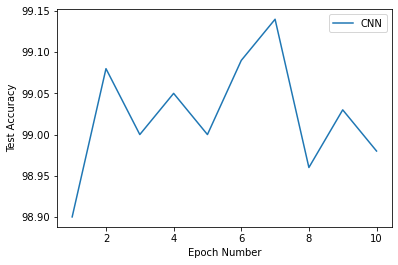

In [6]:
import matplotlib.pyplot as plt

plt.plot(epoch_number, accuracy_values, label='CNN')

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Test Accuracy")

# Show the plot
plt.show()
